# <center>Análise dos filmes e séries presentes no catálogo da Netflix<center>

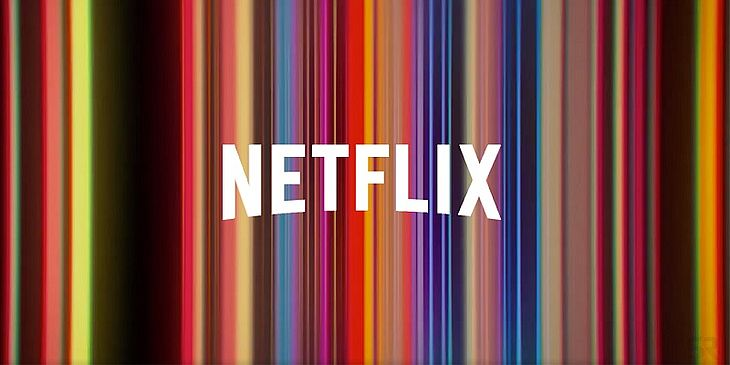

In [33]:
import os
from IPython.display import Image
PATH = r"C:\Users\Eduarda\Documents\Data Analysis\Netflix"
Image(filename = PATH + "\\net.jpg", width=900, height=700)

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import datetime as dt
import calendar
import warnings
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore") 
from collections import Counter
%matplotlib inline 

C:\Users\Eduarda\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Lendo o dataframe
ntf = pd.read_csv(r"C:\Users\Eduarda\Documents\Data Analysis\Netflix\netflix_titles.csv")

# Setando as configurações de visualização

In [3]:
# Configurando o tamanho das imagens plotadas
sns.set(rc={'figure.figsize':(12,10)})
sns.set_style('whitegrid')

# Setando a visualização das colunas do df
pd.set_option("display.max_columns",None)

In [4]:
# Visualizando o dataframe
ntf.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


# Tratamento dos dados

In [5]:
# Verificando a qtd de valores nulos no df
ntf.isnull().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

In [6]:
# Retirando valores nulos 
ntf = ntf.dropna(subset=['date_added'])

In [7]:
# Extraindo as informações de ano, mês e dia
ntf['month_added'] = pd.to_datetime(ntf['date_added'],errors='coerce').dt.month
ntf['year_added'] = pd.to_datetime(ntf['date_added'],errors='coerce').dt.year
ntf['day_added'] = pd.to_datetime(ntf['date_added'],errors='coerce').dt.day

In [8]:
# Aplicando as funções para extrair as informações de ano, mês e dia que os filmes/séries foram add na lista
def month_added(x):
    return calendar.month_name[x]


ntf['month_added_name'] = ntf['month_added'].apply(lambda x: month_added(x) if x != np.nan else np.nan)

#Retirando a coluna de date_added
ntf.drop(columns=['date_added'],inplace=True)

In [9]:
# Add a coluna referente ao tempo de diferença em que o filme foi lançado e quando foi add no catálogo da netflix
ntf['release_year'] = ntf['release_year'].astype('int32')
ntf['year_added'] = pd.to_numeric(ntf['year_added'],errors='coerce')
ntf['delta_time_year'] = ntf['year_added'] - ntf['release_year']

In [10]:
# retirando a informação de season
ntf['season_count'] = ntf.apply(lambda x : x['duration'].split(" ")[0] if "Season" in x['duration'] else np.nan, axis = 1)
ntf['duration'] = ntf.apply(lambda x : x['duration'].split(" ")[0] if "Season" not in x['duration'] else np.nan, axis = 1)
ntf['duration'] =  ntf['duration'].apply(lambda x : float(x) if x != np.nan else np.nan)

In [11]:
ntf['month_added_name'].unique()

array(['September', 'October', 'November', 'May', 'March', 'June', 'July',
       'January', 'February', 'December', 'August', 'April'], dtype=object)

In [12]:
# Mudando o nome do mês para português
def nome_mes(x):
    if x.strip() == 'January':
        return 'Jan'
    elif x.strip() == 'February':
        return 'Fev'
    elif x.strip() == 'March':
        return 'Mar'
    elif x.strip() == 'April':
        return 'Abr'
    elif x.strip() == 'May':
        return 'Mai'
    elif x.strip() == 'June':
        return 'Jun'
    elif x.strip() == 'July':
        return 'Jul'
    elif x.strip() == 'August':
        return 'Ago'
    elif x.strip() == 'September':
        return 'Set'
    elif x.strip() == 'October':
        return 'Out'
    elif x.strip() == 'November':
        return 'Nov'
    elif x.strip() == 'December':
        return 'Dez'
    
ntf['month_added_name'] = ntf['month_added_name'].apply(lambda x: nome_mes(x))

In [13]:
# Dividindo o dataset em filmes e séries
filmes = ntf.loc[ntf['type'] == 'Movie']
series = ntf.loc[ntf['type'] == 'TV Show']

In [14]:
ntf.head()

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description,month_added,year_added,day_added,month_added_name,delta_time_year,season_count
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019,TV-PG,90.0,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,9,2019,9,Set,0,NaN
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016,TV-MA,94.0,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,9,2016,9,Set,0,NaN
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2013,TV-Y7-FV,NaN,Kids' TV,"With the help of three human allies, the Autob...",9,2018,8,Set,5,1
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2016,TV-Y7,NaN,Kids' TV,When a prison ship crash unleashes hundreds of...,9,2018,8,Set,2,1
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017,TV-14,99.0,Comedies,When nerdy high schooler Dani finally attracts...,9,2017,8,Set,0,NaN


# <center>TASKS<center>

# Tipo de produção

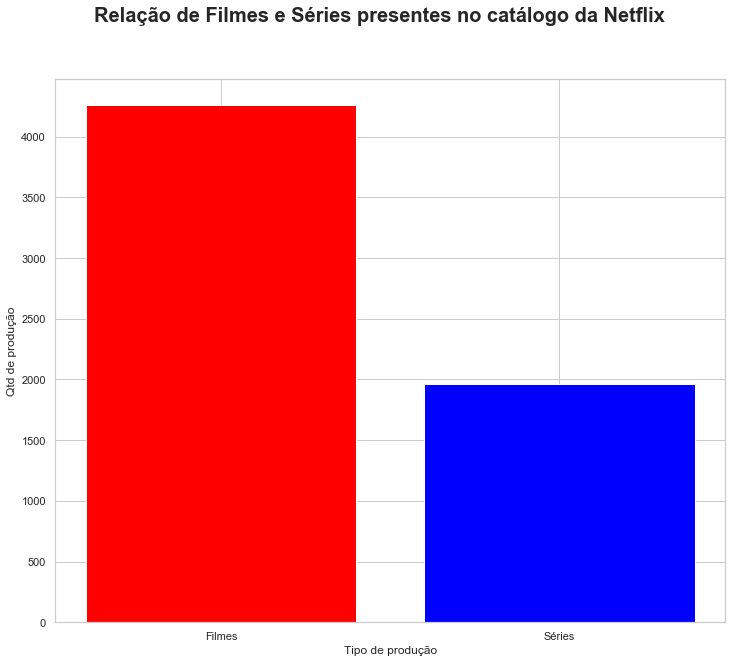

In [15]:
qtd_type = pd.DataFrame(ntf.groupby('type')['show_id'].count()).reset_index()
qtd_type.replace(['Movie','TV Show'],['Filmes','Séries'],inplace=True)
plt.bar(qtd_type['type'],qtd_type['show_id'],color=['red','blue'])
plt.suptitle('Relação de Filmes e Séries presentes no catálogo da Netflix',fontsize=20,weight='bold')
plt.xlabel('Tipo de produção')
plt.ylabel('Qtd de produção')
plt.show()

# Qual é o mês que obtém a maior quantidade de filmes lançados no catálogo ? 

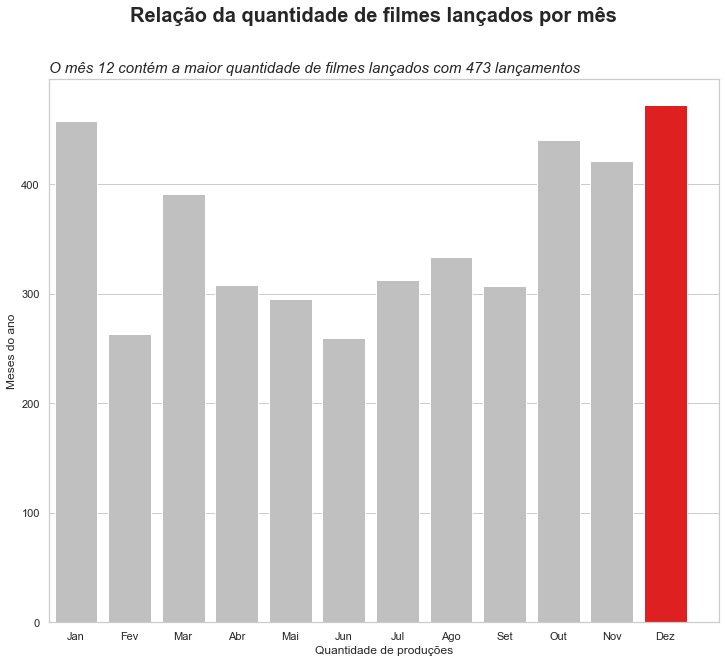

In [47]:
filmes_month = pd.DataFrame(filmes.groupby(['month_added'])['type'].count()).reset_index()
filmes_month = filmes_month.sort_values(by='month_added',ascending=True)

clrs = ['silver' if (x < max(filmes_month['type'])) else 'red' for x in  filmes_month['type']]
sns.barplot(x='month_added',y='type',data=filmes_month,palette=clrs)
plt.xticks(np.arange(0,13),['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez'])
plt.xlabel('Quantidade de produções')
plt.ylabel('Meses do ano')
plt.suptitle('Relação da quantidade de filmes lançados por mês',fontsize=20,weight='bold')
plt.title(f'O mês {filmes_month.loc[11][0]} contém a maior quantidade de filmes lançados com {filmes_month.loc[11][1]} lançamentos',loc='left',fontsize=15,fontstyle='oblique')
plt.show()

# Qual é o mês que obtém a maior quantidade de séries lançadas no catálogo ?

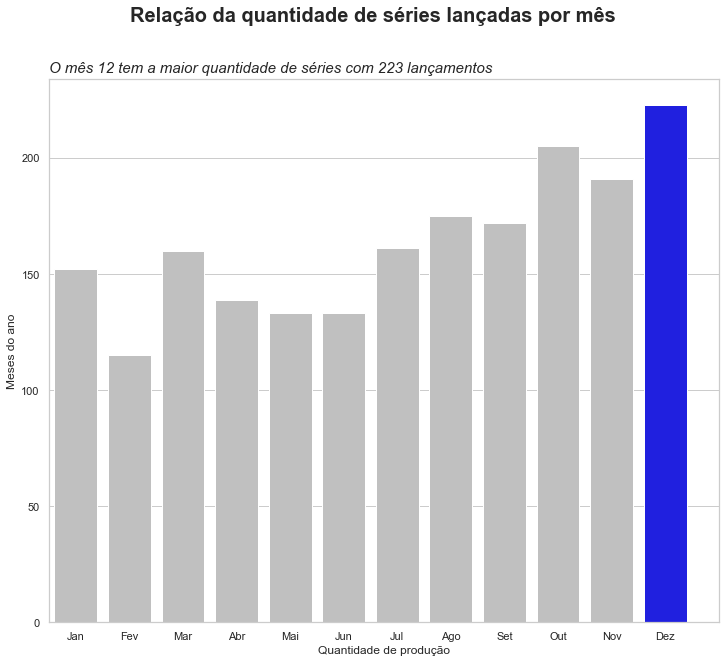

In [53]:
series_month = pd.DataFrame(series.groupby(['month_added'])['type'].count()).reset_index()
series_month = series_month.sort_values(by='month_added',ascending=True)

clrs = ['silver' if (x < max(series_month['type'])) else 'blue' for x in  series_month['type']]
sns.barplot(x='month_added',y='type',data=series_month,palette=clrs)
plt.xticks(np.arange(0,13),['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez'])
plt.suptitle('Relação da quantidade de séries lançadas por mês',fontsize=20,weight='bold')
plt.title(f'O mês {series_month.loc[11][0]} tem a maior quantidade de séries com {series_month.loc[11][1]} lançamentos',loc='left',fontsize=15,fontstyle='oblique')
plt.xlabel('Quantidade de produção')
plt.ylabel('Meses do ano')
plt.show()

# Top 15 séries com maior quantidade de temporadas

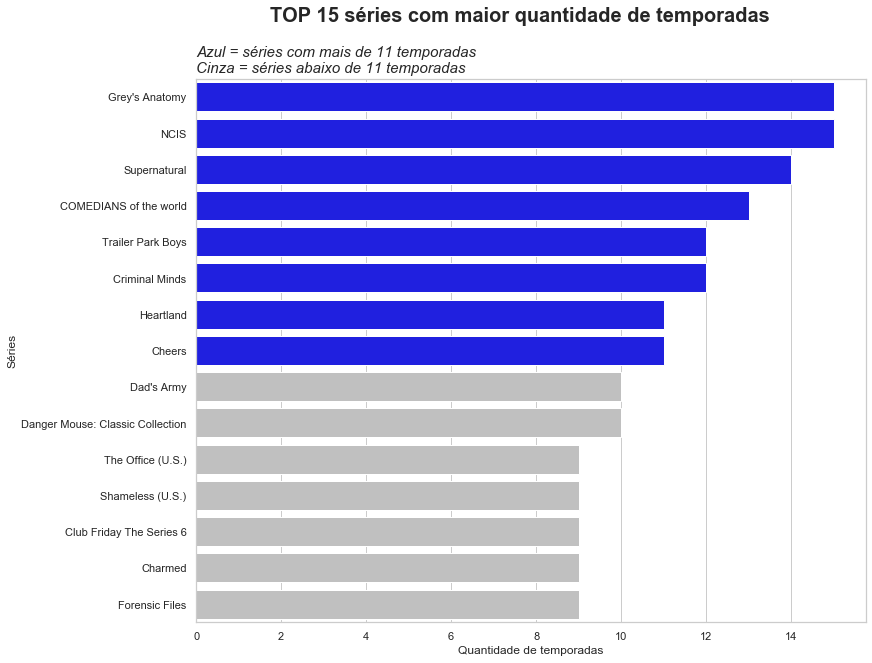

In [138]:
# Mudando o tipo da variável de season_count
series['season_count'] = series['season_count'].astype('int32')

# Visualizando as 15 séries com maior quantidade de temporadas
season = pd.DataFrame(series.groupby('title')['season_count'].sum().sort_values(ascending=False).head(15)).reset_index()
season = season.sort_values(by='season_count',ascending=False)

clrs = [ 'silver' if (x < (season['season_count'].median())) else 'blue' for x in season['season_count']]
sns.barplot(x='season_count',y='title',data=season,palette=clrs,orient='h')
plt.suptitle('TOP 15 séries com maior quantidade de temporadas',fontsize=20,weight='bold')
plt.title('Azul = séries com mais de 11 temporadas\nCinza = séries abaixo de 11 temporadas',loc='left',fontsize=15,fontstyle='oblique')
plt.xlabel('Quantidade de temporadas')
plt.ylabel('Séries')
plt.show()

# Qual é o dia que obtém a maior quantidade de adição de filmes e séries no catálogo?

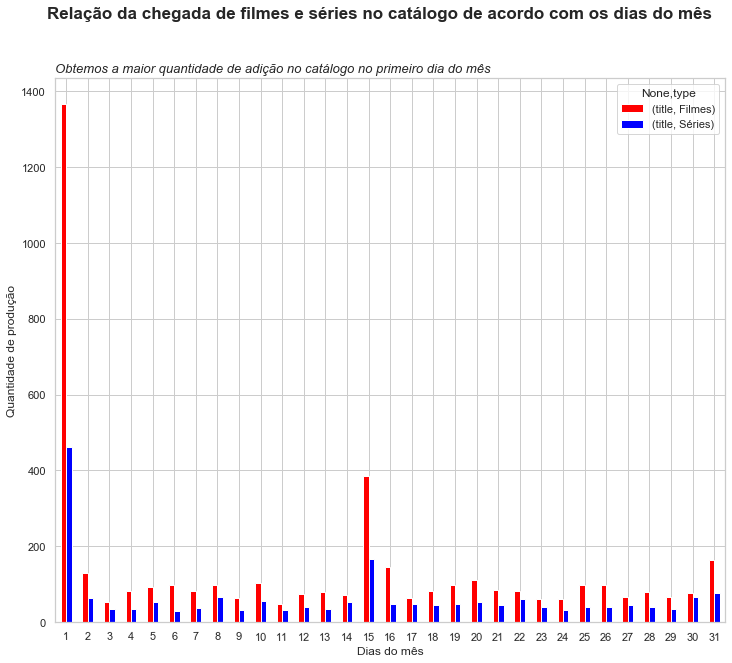

In [60]:
ntf_day = pd.DataFrame(ntf.groupby(['day_added','type'])['title'].count()).unstack()
ntf_day.columns.set_levels(['Filmes','Séries'],level=1,inplace=True)
ntf_day.plot(kind="bar",stacked=False,rot=1,color=['red','blue'])
plt.xlabel('Dias do mês')
plt.ylabel('Quantidade de produção')
plt.suptitle('Relação da chegada de filmes e séries no catálogo de acordo com os dias do mês',fontsize=17,weight='bold')
plt.title('Obtemos a maior quantidade de adição no catálogo no primeiro dia do mês',fontsize=13,fontstyle='oblique',loc='left')
plt.show()

# Relação do lançamento de filmes e séries no catálogo

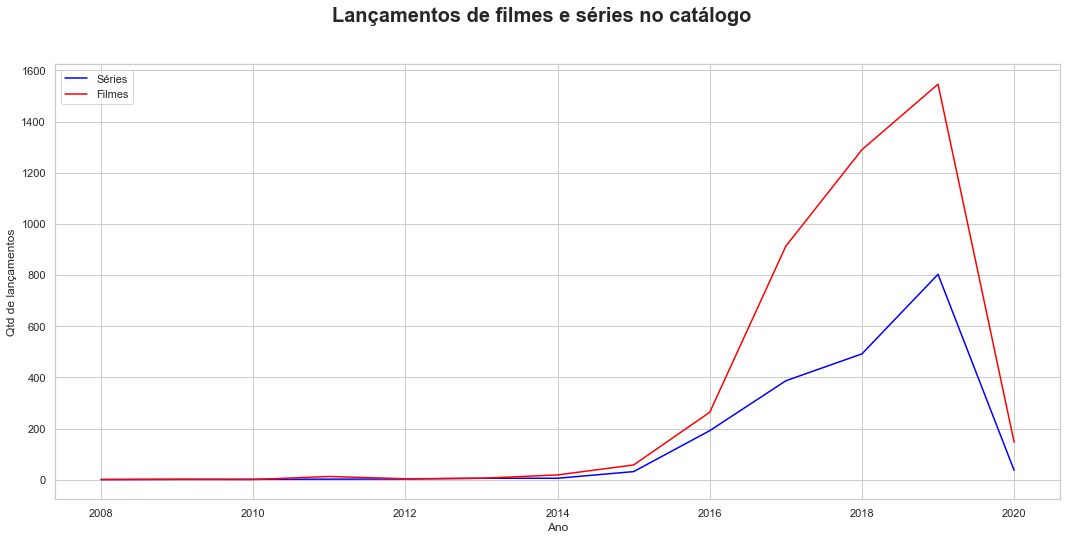

In [74]:
yr_s = series.loc[series['year_added'] > 2000]
yr_s.rename(columns={'type':'Séries'},inplace=True)
yr_s = yr_s.groupby(['year_added'])['Séries'].count()
yr_f = filmes.loc[filmes['year_added'] > 2000]
yr_f.rename(columns={'type':'Filmes'},inplace=True)
yr_f =yr_f.groupby(['year_added'])['Filmes'].count()
plt.figure(figsize=(18,8))
yr_s.plot(color='blue',legend='Séries')
yr_f.plot(color='red',legend='Filmes')
plt.suptitle("Lançamentos de filmes e séries no catálogo",fontsize=20,weight = 'bold')
plt.xlabel('Ano')
plt.ylabel('Qtd de lançamentos')
plt.legend(loc='upper left')
plt.show()

# Ano

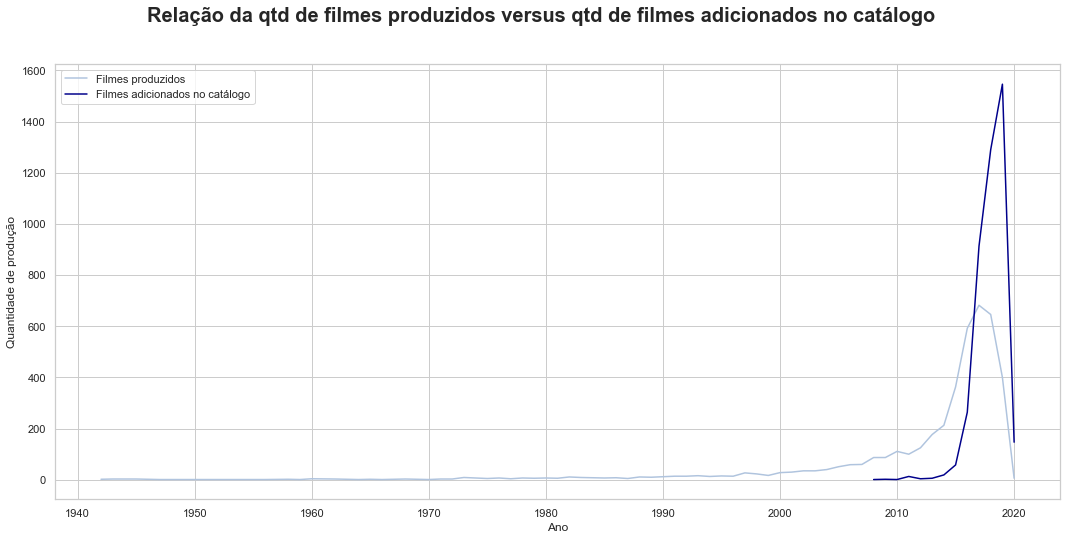

In [75]:
yr = filmes.groupby(['release_year'])['release_year'].count()
yr.name = 'Filmes produzidos'
ya = filmes.groupby(['year_added'])['year_added'].count()
ya.name = 'Filmes adicionados no catálogo'
plt.figure(figsize=(18,8))
yr.plot(color='lightsteelblue')
ya.plot(color='darkblue')
plt.suptitle("Relação da qtd de filmes produzidos versus qtd de filmes adicionados no catálogo",fontsize=20,weight = 'bold')
plt.ylabel('Quantidade de produção')
plt.xlabel('Ano')
plt.legend()
plt.show()

# Gênero

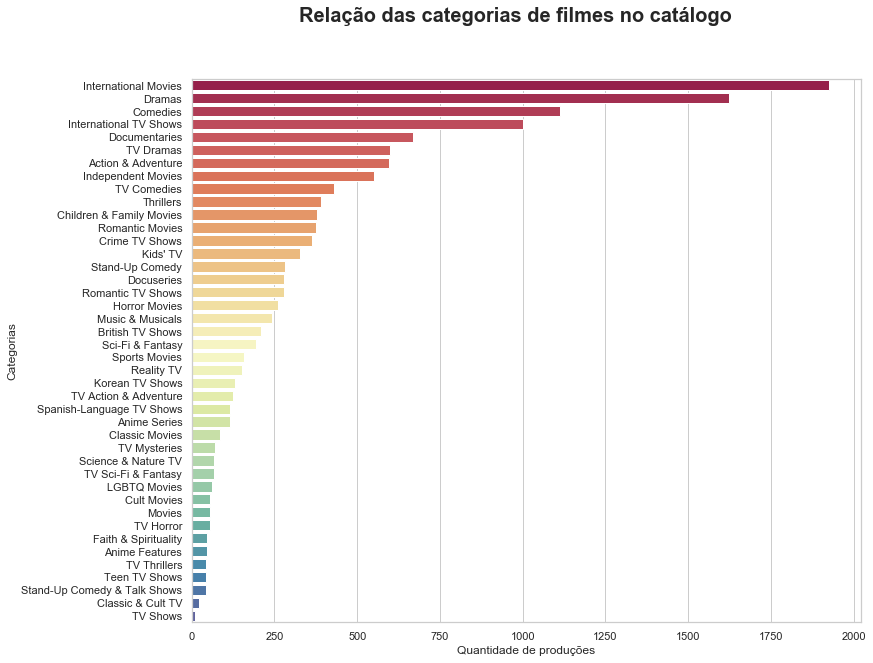

In [182]:
categories = ", ".join(ntf['listed_in']).split(", ")

counter_list = Counter(categories).most_common(50)
cat = [k[0] for c,k in enumerate(counter_list)]
values = [k[1] for c,k in enumerate(counter_list)]

sns.barplot(x=values,y=cat,palette='Spectral')
plt.xlabel('Quantidade de produções')
plt.ylabel('Categorias')
plt.suptitle("Relação das categorias de filmes no catálogo",fontsize=20,weight = 'bold')
plt.show()

# Duração

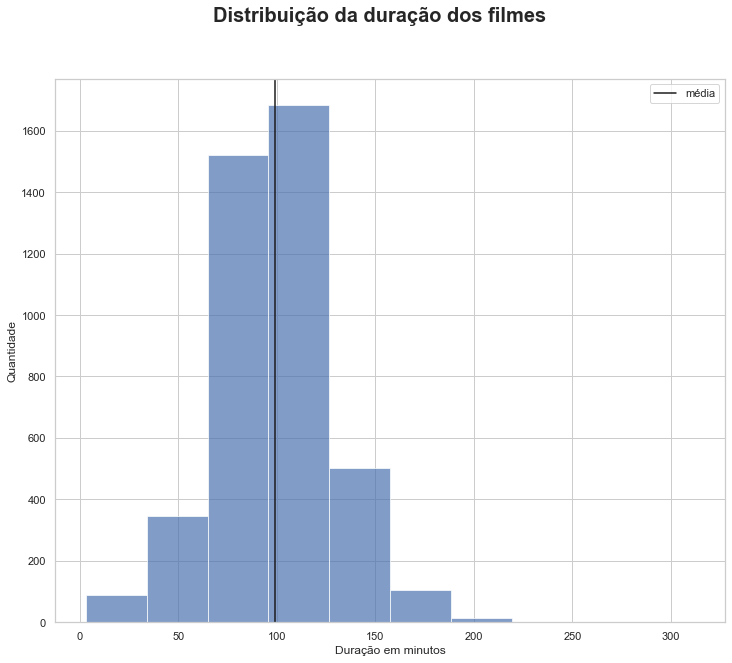

In [77]:
# Visualização da distribuição da duração dos filmes
plt.hist(filmes['duration'],color='b',alpha=0.7,bins=10)
plt.axvline(filmes['duration'].mean(), 0,1, color = 'k',label='média');
plt.xlabel('Duração em minutos')
plt.ylabel('Quantidade')
plt.suptitle('Distribuição da duração dos filmes',fontsize=20,weight = 'bold')
plt.legend()
plt.show()

In [78]:
# Top 10 filmes com maiores durações
time = pd.DataFrame(filmes.groupby('title')['duration'].sum().sort_values(ascending=False).reset_index()).head(10)
time

,title,duration
0,Don,327.0
1,Sarkar,324.0
2,Black Mirror: Bandersnatch,312.0
3,Prince,282.0
4,The Silence,272.0
5,Love,255.0
6,One Day,242.0
7,Solo,241.0
8,Carrie,230.0
9,Sangam,228.0


In [79]:
# Top 10 filmes com menores durações
time_less = pd.DataFrame(filmes.groupby('title')['duration'].sum().sort_values(ascending=True).reset_index()).head(10)
time_less

,title,duration
0,Silent,3.0
1,American Factory: A Conversation with the Obamas,10.0
2,Calico Critters: A Town of Dreams,11.0
3,Zion,12.0
4,Cosmos Laundromat: First Cycle,12.0
5,Buddy Thunderstruck: The Maybe Pile,14.0
6,The Road to El Camino: Behind the Scenes of El...,14.0
7,ANIMA,15.0
8,The Battle of Midway,18.0
9,Pocoyo & Cars,19.0


# País

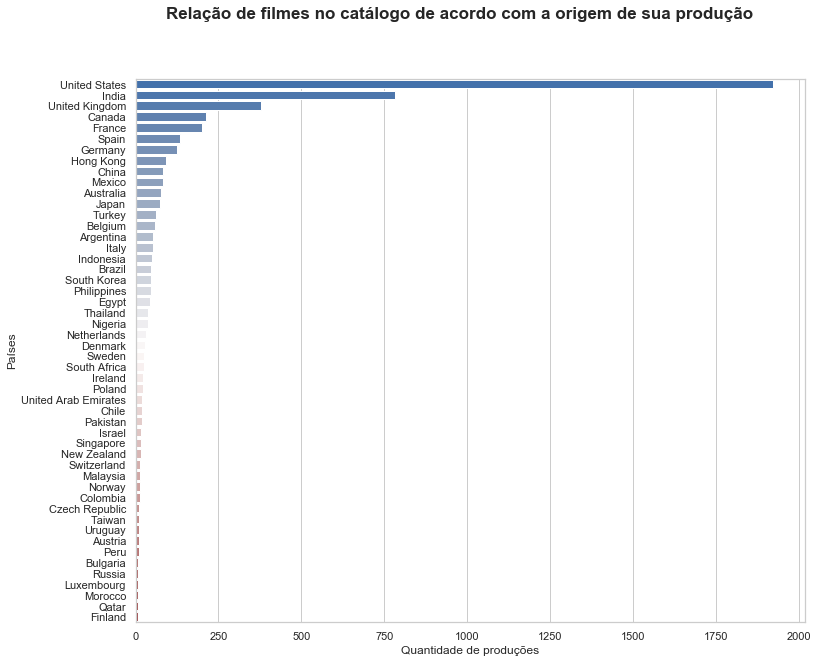

In [65]:
paises = filmes.loc[filmes['country'].notnull()]
paises = ", ".join(paises['country']).split(", ")

country_list = Counter(paises).most_common(50)
pais = [x[0] for x in country_list]
qtd = [x[1] for x in country_list]

sns.barplot(y=pais,x=qtd,orient='h',palette='vlag')
plt.xlabel('Quantidade de produções')
plt.ylabel('Países')
plt.suptitle("Relação de filmes no catálogo de acordo com a origem de sua produção",fontsize=17,weight = 'bold')
plt.show()

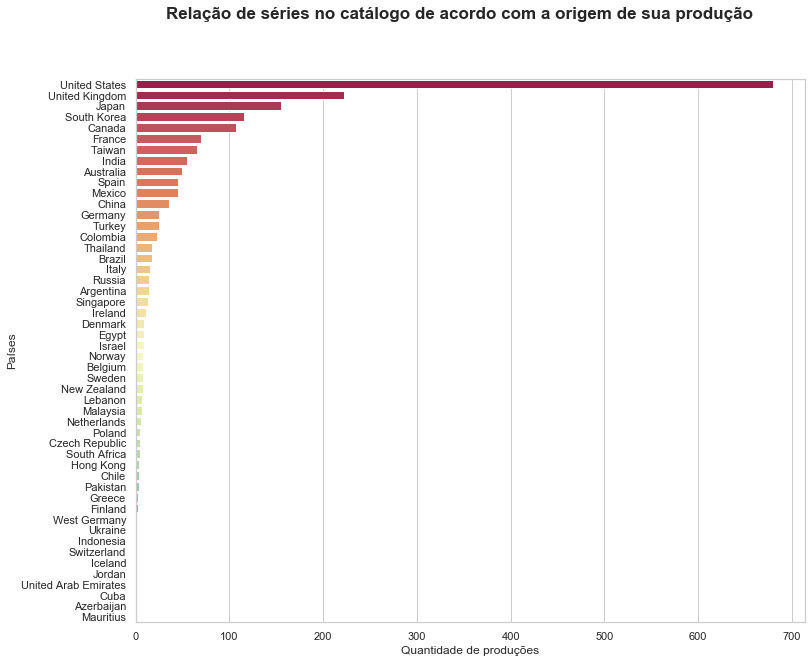

In [67]:
paises = series.loc[series['country'].notnull()]
paises = ", ".join(paises['country']).split(", ")

country_list = Counter(paises).most_common(50)
pais = [x[0] for x in country_list]
qtd = [x[1] for x in country_list]

sns.barplot(y=pais,x=qtd,orient='h',palette='Spectral')
plt.xlabel('Quantidade de produções')
plt.ylabel('Países')
plt.suptitle("Relação de séries no catálogo de acordo com a origem de sua produção",fontsize=17,weight = 'bold')
plt.show()

# Classificação de Idade

Legenda:
* TV-MA | NC-17: Audiência madura — não recomendado para menores de 17 anos
* TV-PG: Classificação destinada com a orientação parental
* TV-Y7-FV: Não recomendado para menores de 7 anos com violência fantasiosa
* TV-Y7: Não recomendado para menores de 7 anos
* TV-14 : Não recomendado para menores de 14 anos
* PG-13: Não recomendado para menores de 13 anos
* TV-Y: Conteúdo Infantil
* NR: sem classificação definida
* TV-G | G: Recomendado para todos os públicos
* PG: Não recomendado para crianças
* UR:
* R: Menores de 17 anos requerem acompanhamento dos pais ou guardiões adultos

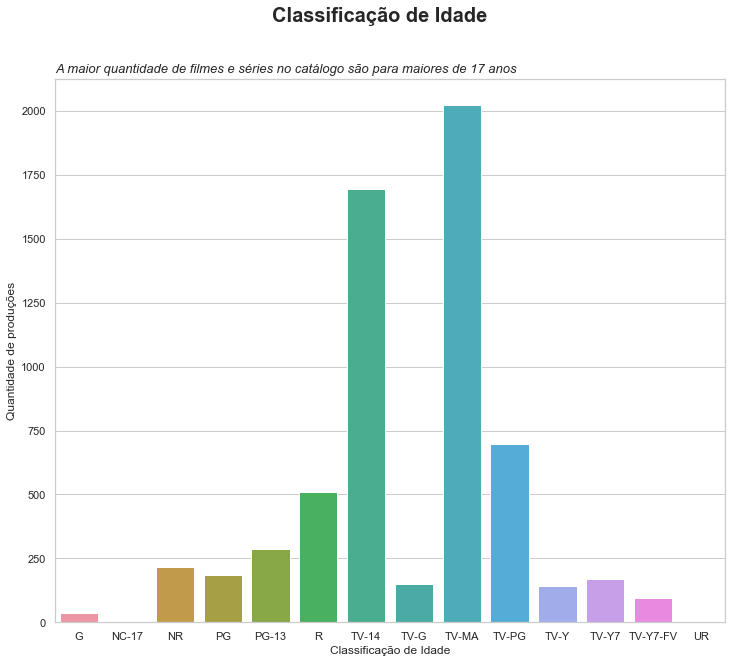

In [185]:
ntf_idade = pd.DataFrame(ntf.groupby('rating')['title'].count()).reset_index()
sns.barplot(x=ntf_idade['rating'],y=ntf_idade['title'],data=ntf_idade)
plt.xlabel('Classificação de Idade')
plt.ylabel('Quantidade de produções')
plt.suptitle('Classificação de Idade',fontsize=20,weight='bold')
plt.title('A maior quantidade de filmes e séries no catálogo são para maiores de 17 anos',fontsize=13,loc='left',fontstyle='oblique')
plt.show()

# Elenco dos filmes

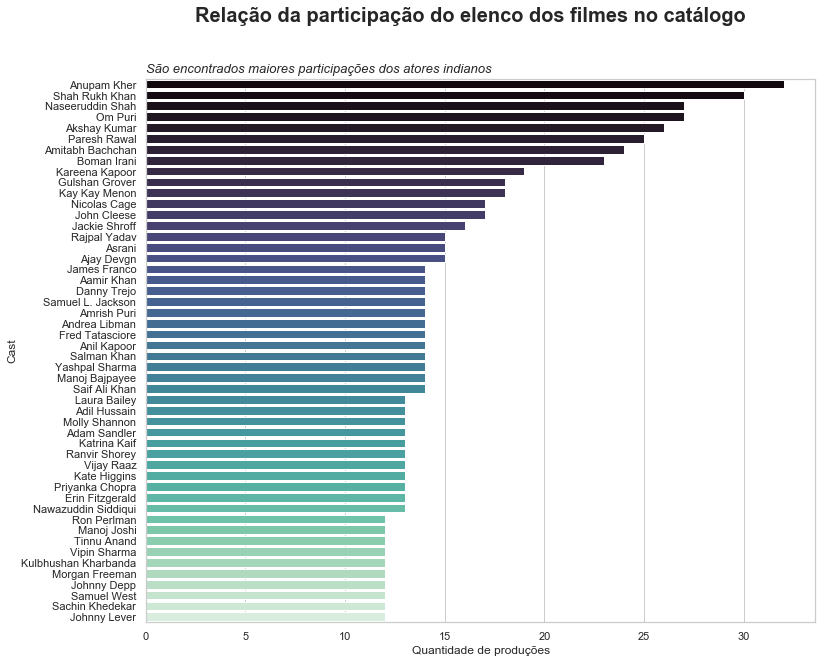

In [68]:
lista_cast = filmes.loc[filmes['cast'].notnull()]
cast_filmes = ", ".join(lista_cast['cast']).split(", ")

cast1_list = Counter(cast_filmes).most_common(50)

cast_1 = [k[0] for c,k in enumerate(cast1_list)]
values_1 = [k[1] for c,k in enumerate(cast1_list)]

sns.barplot(x=values_1,y=cast_1,palette='mako')
plt.xlabel('Quantidade de produções')
plt.ylabel('Cast')
plt.suptitle("Relação da participação do elenco dos filmes no catálogo",fontsize=20,weight = 'bold')
plt.title('São encontrados maiores participações dos atores indianos',loc='left',fontstyle='oblique',fontsize=13)
plt.show()

# Descrição

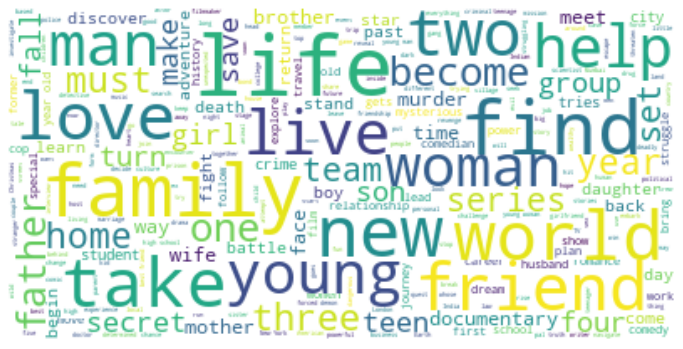

In [190]:
text = " ".join(review for review in ntf.description)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white").generate(text)
plt.figure()

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Analisando produções de temática LGBTQ

In [80]:
ntf_lgbt = filmes.loc[filmes['listed_in'].str.contains('LGBT')]
ntf_lgbt.head()

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description,month_added,year_added,day_added,month_added_name,delta_time_year,season_count
159,81122669,Movie,Daddy Issues,Amara Cash,"Madison Lawlor, Montana Manning, Andrew Pifko,...",United States,2019,TV-MA,82.0,"Dramas, Independent Movies, LGBTQ Movies",Maya finally hooks up with her online dream gi...,9,2019,20,Set,0,NaN
399,80173269,Movie,Who the F**k Is That Guy?,Drew Stone,Michael Alago,United States,2017,TV-MA,78.0,"Documentaries, LGBTQ Movies, Music & Musicals",Take a ride through the life of record exec Mi...,9,2017,1,Set,0,NaN
441,80189623,Movie,The Death and Life of Marsha P. Johnson,David France,NaN,United States,2017,TV-MA,106.0,"Documentaries, LGBTQ Movies",As she fights the tide of violence against tra...,10,2017,6,Out,0,NaN
746,80216844,Movie,Feminists: What Were They Thinking?,Johanna Demetrakas,NaN,United States,2018,TV-MA,86.0,"Documentaries, LGBTQ Movies",Revisiting 1970s photos of women that captured...,10,2018,12,Out,0,NaN
1013,80201542,Movie,Let It Snow,Luke Snellin,"Isabela Moner, Shameik Moore, Kiernan Shipka, ...",United States,2019,PG-13,93.0,"Comedies, Dramas, LGBTQ Movies",A snowstorm hits a small town on a cold Christ...,11,2019,8,Nov,0,NaN


# Gênero dos filmes

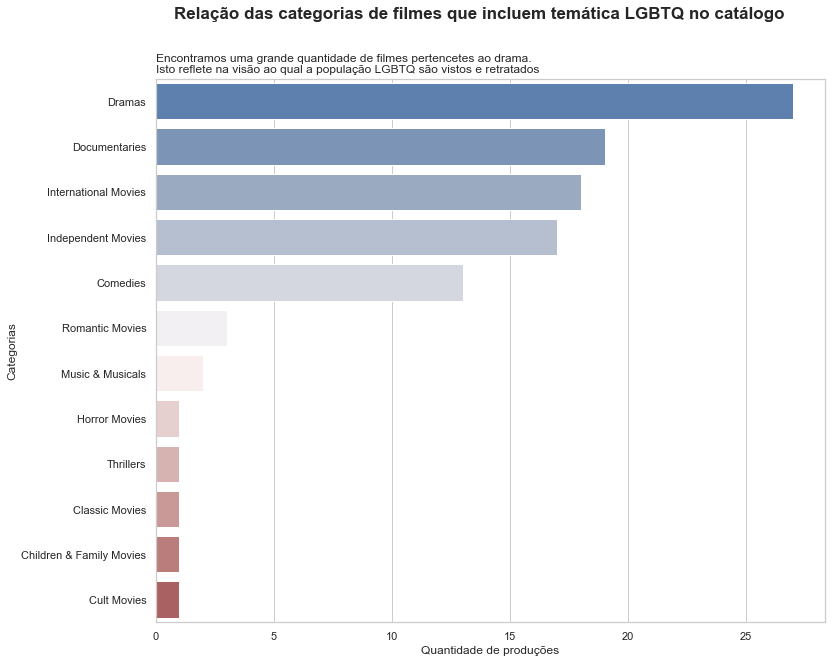

In [77]:
col = "listed_in"
categories = ", ".join(ntf_lgbt['listed_in']).split(", ")

counter_list = Counter(categories).most_common(50)
cat = [k[0] if k[0] != 'LGBTQ Movies' else np.nan for c,k in enumerate(counter_list)]
values = [k[1] for c,k in enumerate(counter_list)]

sns.barplot(x=values,y=cat,palette='vlag')
plt.xlabel('Quantidade de produções')
plt.ylabel('Categorias')
plt.suptitle("Relação das categorias de filmes que incluem temática LGBTQ no catálogo",fontsize=17,weight = 'bold')
plt.title("Encontramos uma grande quantidade de filmes pertencetes ao drama.\nIsto reflete na visão ao qual a população LGBTQ são vistos e retratados",loc='left')
plt.show()

# Classificação da Idade

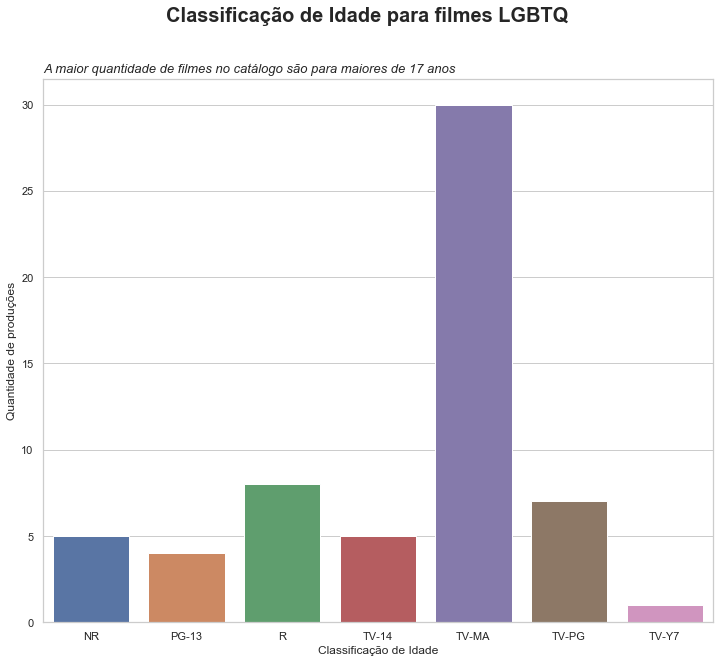

In [81]:
ntf_idade = pd.DataFrame(ntf_lgbt.groupby('rating')['title'].count()).reset_index()
sns.barplot(x=ntf_idade['rating'],y=ntf_idade['title'],data=ntf_idade)
plt.xlabel('Classificação de Idade')
plt.ylabel('Quantidade de produções')
plt.suptitle('Classificação de Idade para filmes LGBTQ',fontsize=20,weight='bold')
plt.title('A maior quantidade de filmes no catálogo são para maiores de 17 anos',fontsize=13,loc='left',fontstyle='oblique')
plt.show()

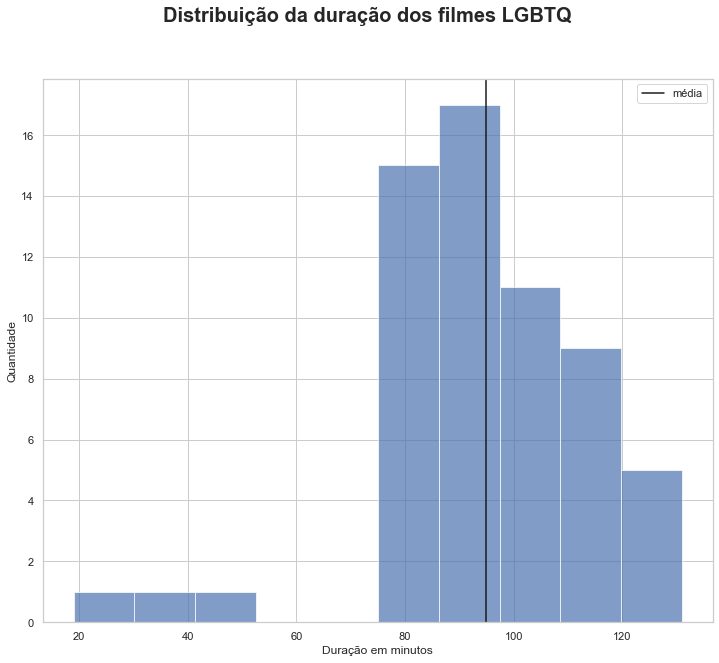

In [105]:
# Visualização da distribuição da duração dos filmes
plt.hist(ntf_lgbt['duration'],color='b',alpha=0.7,bins=10)
plt.axvline(ntf_lgbt['duration'].mean(), 0,1, color = 'k',label='média');
plt.xlabel('Duração em minutos')
plt.ylabel('Quantidade')
plt.suptitle('Distribuição da duração dos filmes LGBTQ',fontsize=20,weight = 'bold')
plt.legend()
plt.show()

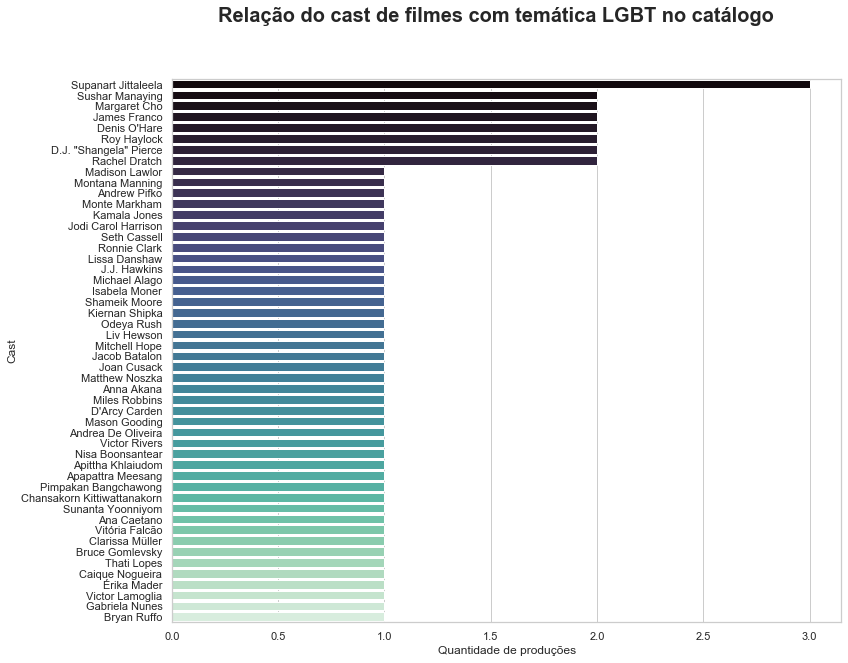

In [191]:
lista = ntf_lgbt.loc[ntf_lgbt['cast'].notnull()]
cast = ", ".join(lista['cast']).split(", ")

cast_list = Counter(cast).most_common(50)

cast = [k[0] for c,k in enumerate(cast_list)]
values = [k[1] for c,k in enumerate(cast_list)]

sns.barplot(x=values,y=cast,palette='mako')
plt.xlabel('Quantidade de produções')
plt.ylabel('Cast')
plt.suptitle("Relação do cast de filmes com temática LGBT no catálogo",fontsize=20,weight = 'bold')
plt.show()